### Example Notebook of all SSA / ODE methods

In [42]:
#setup, lets load a large gene (HUMINSR) ~1700bp
import numpy as np
import os
import time
os.chdir('../..')

import rsnapsim as rss
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = False

os.chdir('./rsnapsim/interactive_notebooks')

poi_str,proteins,tagged_proteins,seq = rss.seqmanip.open_seq_file('../gene_files/HUMINSR.gb')
poi = proteins['1'][0]  #protein object
rss.solver.protein=poi

t = np.linspace(0,500,501)


In [43]:
tau,means,var = rss.solver.solve_ballistic_model(poi.ki,poi.ke)
print("ballistic ribosome mean: %f" % means[0])
print("ballistic intensity mean: %f" % (means[0]*10) )

ballistic ribosome mean: 4.385248
ballistic intensity mean: 43.852476


C:\Users\willi\Documents\GitHub\rSNAPsim\rsnapsim\poi.py:315: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


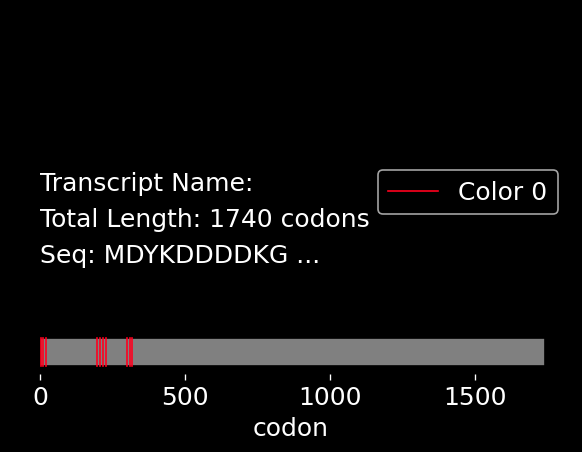

In [44]:
poi.visualize_probe()

### SSA Solutions

Flags for how much data to return:

#### Record stats 

    Return collision statistics and ribosome residence times 
    
#### Low Memory 

    Return full position tensor

Low memory, no recording: solved in 0.948817 seconds


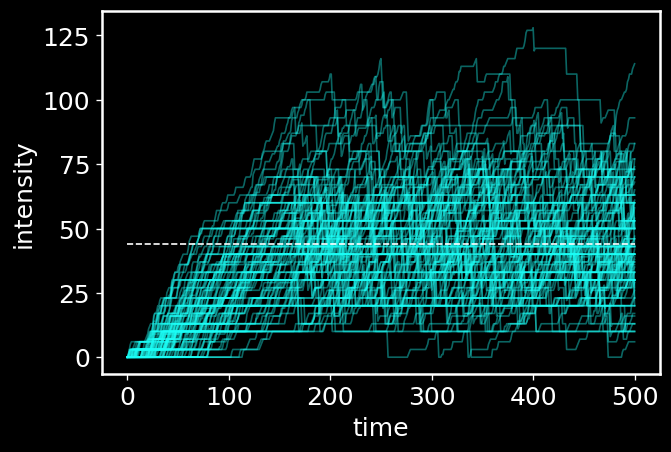

In [45]:

#with recording and low memory
sttime = time.time()
ssa_soln = rss.solver.solve_ssa(poi.kelong,t,ki=.033,n_traj=100)
solvetime = time.time()-sttime

low_mem_time = solvetime
plt.plot(ssa_soln.intensity_vec[0],color='#1cfff7',alpha=.4)
plt.xlabel('time')
plt.ylabel('intensity')
print("Low memory, no recording: solved in %f seconds" % solvetime)

plt.plot([0,500],[means[0]*10,means[0]*10],'w--')



Text(0.5, 1.0, 'Autocorrelation')

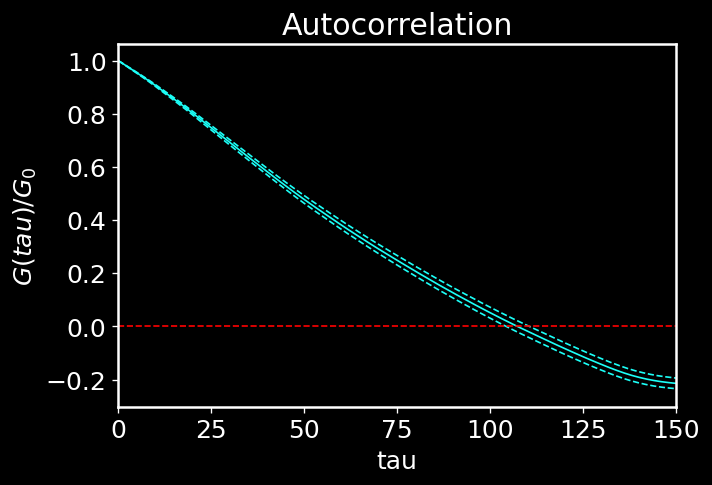

In [46]:
acov,err_acov = rss.inta.get_autocov(ssa_soln.intensity_vec,norm='ind')

acc,err_acc = rss.inta.get_autocorr(acov)
n_traj = acc.shape[-1]

plt.plot(np.mean(acc[0],axis=1),color='#1cfff7');
plt.plot(np.mean(acc[0],axis=1) - err_acc[0],'--',color='#1cfff7');
plt.plot(np.mean(acc[0],axis=1)+ err_acc[0],'--',color='#1cfff7');
plt.plot([0,500],[0,0],'r--')
plt.xlim([0,150])
plt.ylabel('$G(tau)/G_0$')
plt.xlabel('tau')
plt.title('Autocorrelation')


Low memory, w/ recording: solved in 1.383891 seconds


Text(0.5, 1.0, 'Collisions per location over all 100 Trajectories')

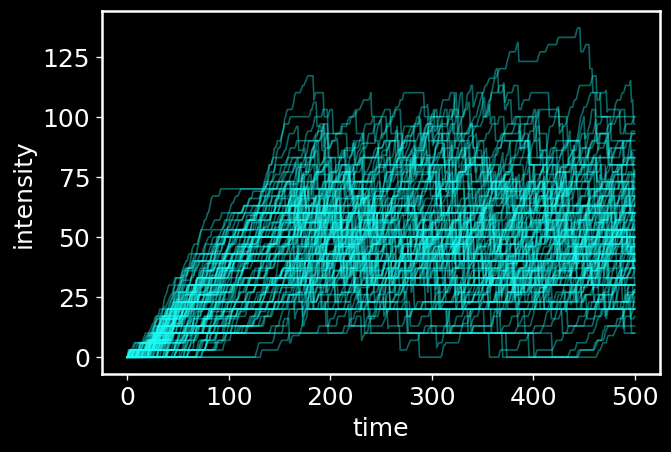

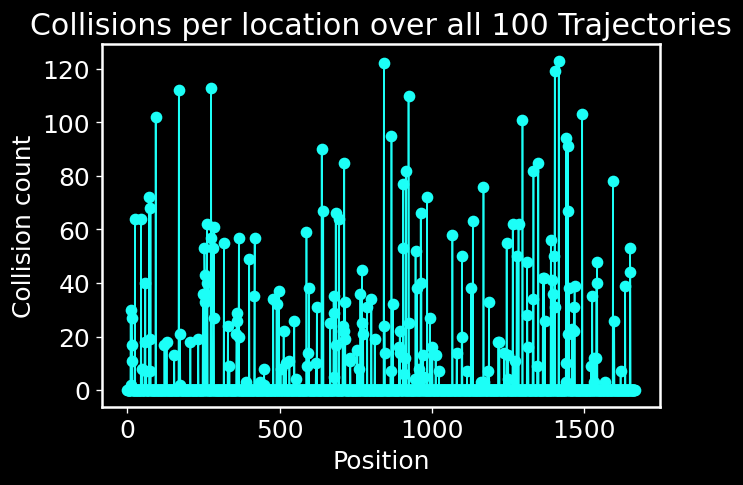

In [47]:
#Default settings, no stats recording and low memory
sttime = time.time()
ssa_soln2 = rss.solver.solve_ssa(poi.kelong,t,ki=.033,n_traj=100,record_stats=True )
solvetime = time.time()-sttime
recording_stats_time = solvetime
plt.plot(ssa_soln2.intensity_vec[0],color='#1cfff7',alpha=.4)
plt.xlabel('time')
plt.ylabel('intensity')
print("Low memory, w/ recording: solved in %f seconds" % solvetime)

plt.figure()
plt.plot(ssa_soln2.collisions,'-o',color='#1cfff7')
plt.xlabel('Position')
plt.ylabel('Collision count')
plt.title('Collisions per location over all 100 Trajectories')


full memory, with recording: solved in 1.377347 seconds


Text(0.5, 1.0, '2 Trajectories Ribosome posistion over time')

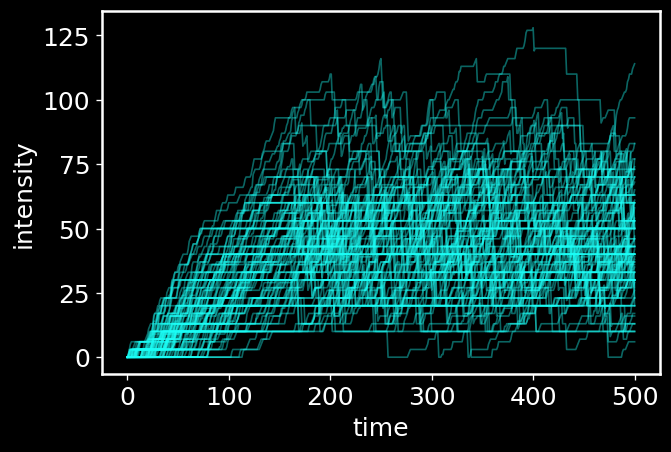

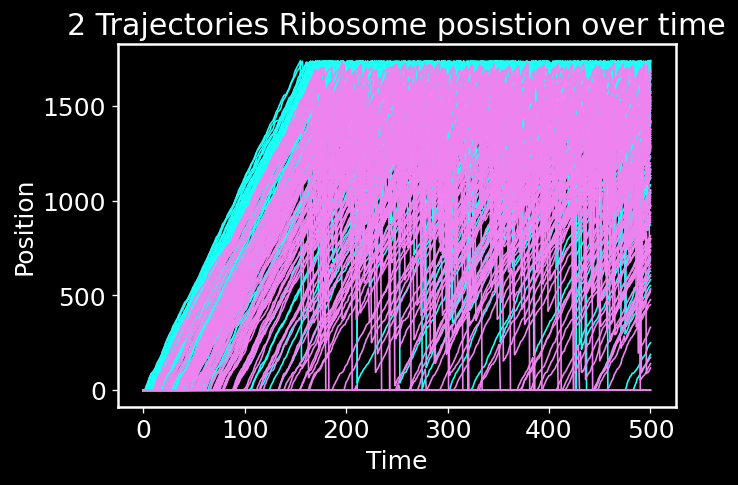

In [48]:
#full solution, returns the ribosome positions
sttime = time.time()
ssa_soln3 = rss.solver.solve_ssa(poi.kelong,t,n_traj=100,ki=.033,record_stats=True,low_memory=False )
solvetime = time.time()-sttime
recording_stats_and_pos_time = solvetime
plt.plot(ssa_soln.intensity_vec[0],color='#1cfff7',alpha=.4)
plt.xlabel('time')
plt.ylabel('intensity')
print("full memory, with recording: solved in %f seconds" % solvetime)


plt.figure()
plt.plot(ssa_soln3.ribosome_locations.T[0],'#1cfff7')
plt.plot(ssa_soln3.ribosome_locations.T[1],'violet')
plt.ylabel('Position')
plt.xlabel('Time')
plt.title('2 Trajectories Ribosome posistion over time')



In [67]:
import sys
def get_obj_mem_size(ssa_soln):
    size = 0

    for key in ssa_soln.__dict__.keys():

        if isinstance(ssa_soln.__dict__[key], np.ndarray):
            size += ssa_soln.__dict__[key].nbytes 
        if isinstance(ssa_soln.__dict__[key], list):
            size += sys.getsizeof(ssa_soln.__dict__[key])
        if isinstance(ssa_soln.__dict__[key], float):
            size += sys.getsizeof(ssa_soln.__dict__[key])
        if isinstance(ssa_soln.__dict__[key], int):
            size += sys.getsizeof(ssa_soln.__dict__[key])
    return size

Text(0, 0.5, 'RAM (mb)')

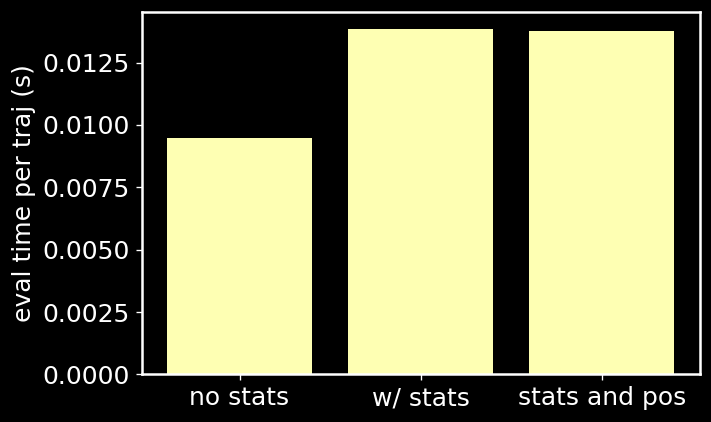

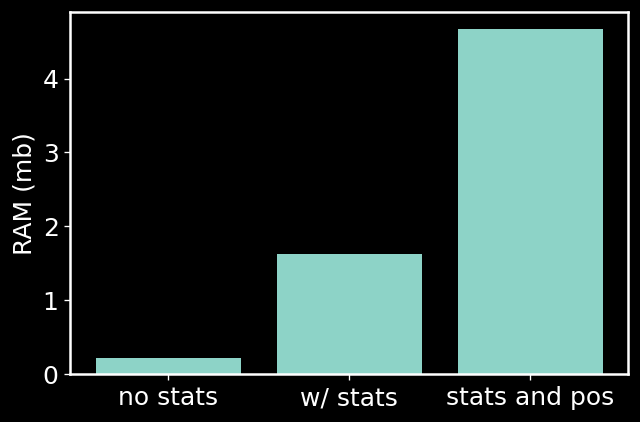

In [72]:
plt.bar([0,1,2],[low_mem_time/100, recording_stats_time/100, recording_stats_and_pos_time/100], tick_label=['no stats', 'w/ stats','stats and pos'])


sols = [ssa_soln,ssa_soln2,ssa_soln3]

mem_sizes = [get_obj_mem_size(x)/1e6 for x in sols]

plt.bar([0,1,2],[low_mem_time/100, recording_stats_time/100, recording_stats_and_pos_time/100], tick_label=['no stats', 'w/ stats','stats and pos'])
plt.ylabel('eval time per traj (s)')

plt.figure()
plt.bar([0,1,2], mem_sizes, tick_label=['no stats', 'w/ stats','stats and pos'])
plt.ylabel('RAM (mb)')

### Binned Solutions / Binning Strategies


### Intellegent Binning (focuses resolution on probe locations)

C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


Text(0.5, 0, 'bin')

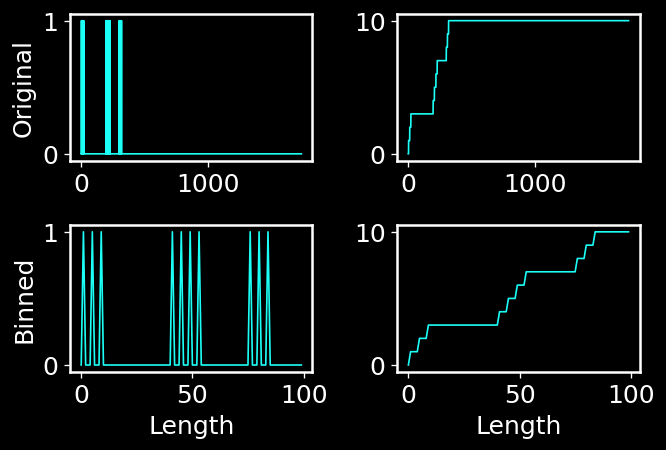

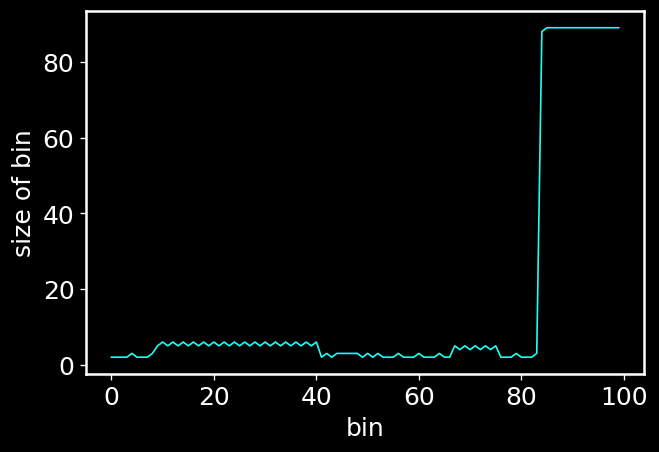

In [77]:
inds = rss.propf.intellegent_bin(np.atleast_2d(poi.probe_loc),100)   
binned_probe_locations,binned_probe_vector = rss.probef.bin_probe_vecs(poi.probe_loc,inds)
kelong_bin = rss.propf.bin_k(poi.kelong, inds)    #

fig,ax = plt.subplots(2,2)

ax[0,0].plot(poi.probe_loc[0],'-',color='#1cfff7')
ax[0,0].set_ylabel('Original')

ax[1,0].plot(binned_probe_locations[0],'-',color='#1cfff7')
ax[1,0].set_xlabel('Length')
ax[1,0].set_ylabel('Binned')

ax[0,1].plot(poi.probe_vec[0],'-',color='#1cfff7')
ax[1,1].plot(binned_probe_vector[0],'-',color='#1cfff7')
ax[1,1].set_xlabel('Length')
plt.tight_layout()
fig.show()


plt.figure()
plt.plot(inds[1:] - inds[:-1],color='#1cfff7')
plt.ylabel('size of bin')
plt.xlabel('bin')


### Even Binning (bin the probe evenly as possible)

C:\Users\willi\Anaconda2\envs\newpy36clone\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


average size of bin: 17.400000


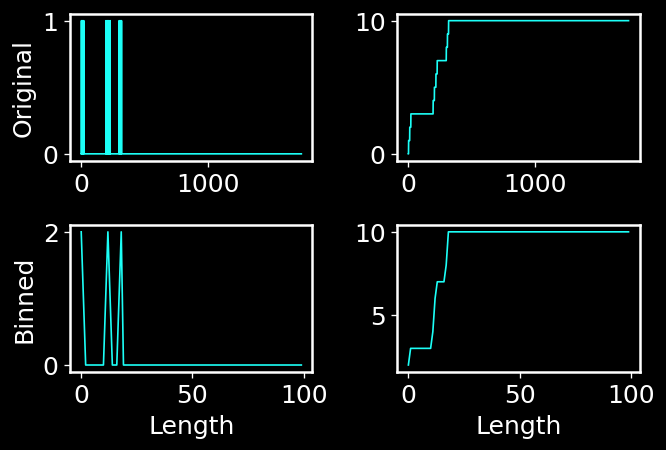

In [79]:
inds = rss.propf.even_bin(poi.probe_loc.shape[1],100)   
binned_probe_locations,binned_probe_vector = rss.probef.bin_probe_vecs(poi.probe_loc,inds)
kelong_bin = rss.propf.bin_k(poi.kelong, inds)    #

fig,ax = plt.subplots(2,2)

ax[0,0].plot(poi.probe_loc[0],'-',color='#1cfff7')
ax[0,0].set_ylabel('Original')
ax[1,0].plot(binned_probe_locations[0],'-',color='#1cfff7')
ax[1,0].set_xlabel('Length')
ax[1,0].set_ylabel('Binned')


ax[0,1].plot(poi.probe_vec[0],'-',color='#1cfff7')
ax[1,1].plot(binned_probe_vector[0],'-',color='#1cfff7')
ax[1,1].set_xlabel('Length')
plt.tight_layout()
fig.show()

print("average size of bin: %f" % np.mean(inds[1:] - inds[:-1]))



### Binned SSA

average dwell time w/bins: 
164.68772434917827
average dwell time no bins: 
164.68772434917824
Low memory, no recording: solved in 0.234043 seconds


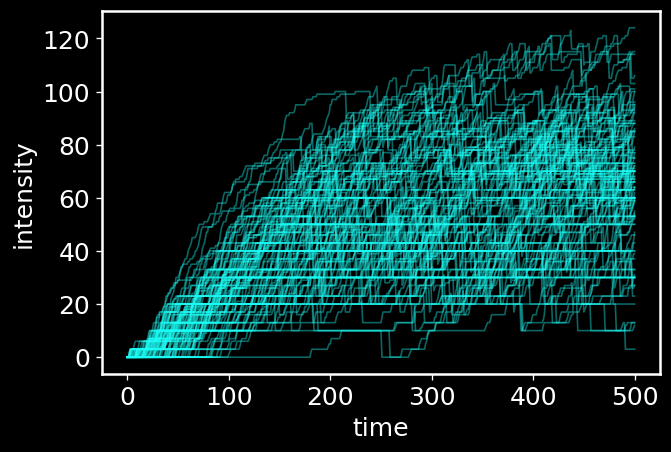

In [81]:
#with recording and low memory


inds = rss.propf.intellegent_bin(np.atleast_2d(poi.probe_loc),200)   
binned_probe_locations,binned_probe_vector = rss.probef.bin_probe_vecs(poi.probe_loc,inds)
kelong_bin = rss.propf.bin_k(poi.kelong, inds)    #

print('average dwell time w/bins: ')
print(np.sum(1/kelong_bin))
print('average dwell time no bins: ')
print(np.sum(1/np.array(poi.kelong)))

sttime = time.time()
ssa_soln = rss.solver.solve_ssa(kelong_bin.tolist(),t,ki=.033,n_traj=100, probe_vec =binned_probe_vector, probe_loc = binned_probe_locations )
solvetime = time.time()-sttime

plt.plot(ssa_soln.intensity_vec[0],color='#1cfff7',alpha=.4)
plt.xlabel('time')
plt.ylabel('intensity')
print("Low memory, no recording: solved in %f seconds" % solvetime)


low memory, with leaky probes: solved in 1.320269 seconds


Text(0.5, 1.0, 'Cyan: kprobe=.8, Violet: kprobe = .2')

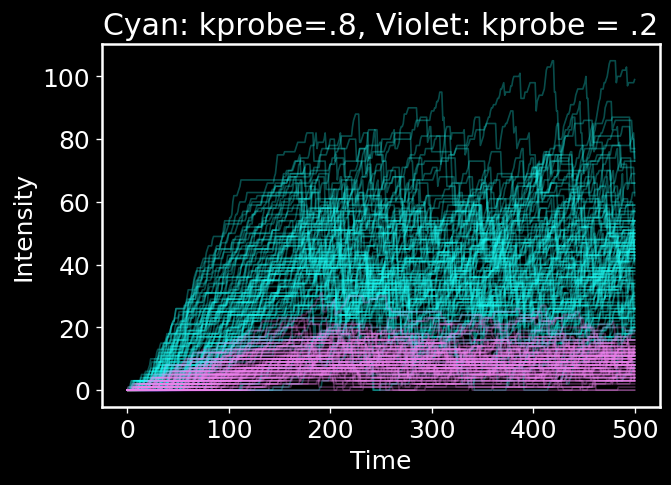

In [82]:
#full solution, returns the ribosome positions
sttime = time.time()
ssa_soln = rss.solver.solve_ssa(poi.kelong,t,ki=.033,n_traj=100,leaky_probes=True, kprobe=np.array([.8]),low_memory=True,record_stats=True)
solvetime = time.time()-sttime


print("low memory, with leaky probes: solved in %f seconds" % solvetime)

plt.figure()
plt.plot(ssa_soln.intensity_vec[0],'#1cfff7',alpha=.3)

ssa_soln = rss.solver.solve_ssa(poi.kelong,t,ki=.033,n_traj=100,leaky_probes=True, kprobe=np.array([.2]),low_memory=True,record_stats=True)


plt.plot(ssa_soln.intensity_vec[0],'violet',alpha=.3)
plt.ylabel('Intensity')
plt.xlabel('Time')
plt.title('Cyan: kprobe=.8, Violet: kprobe = .2')



low memory, with leaky probes: solved in 0.986805 seconds


Text(0.5, 1.0, 'Green: gamma = 1, Violet: gamma = .1')

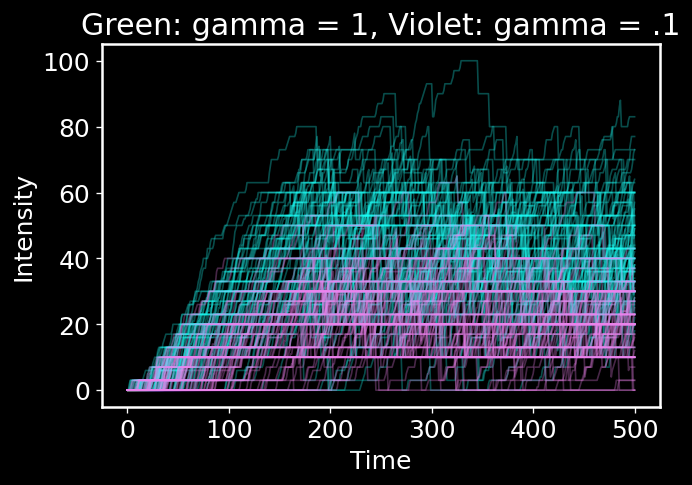

In [83]:
#Bursting

sttime = time.time()
ssa_soln = rss.solver.solve_ssa([.033] + poi.kelong + [10],t,n_traj=100,kon=.5,koff=.5,bursting=True)
solvetime = time.time()-sttime


print("low memory, with leaky probes: solved in %f seconds" % solvetime)

plt.figure()
plt.plot(ssa_soln.intensity_vec[0],'#1cfff7',alpha=.3)

ssa_soln = rss.solver.solve_ssa([.033] + poi.kelong + [10],t,n_traj=100,kon=.5,koff=5,bursting=True)

plt.plot(ssa_soln.intensity_vec[0],'violet',alpha=.3)
plt.ylabel('Intensity')
plt.xlabel('Time')
plt.title('Green: gamma = 1, Violet: gamma = .1')


### ODE solutions

In [92]:
## this should take about 40 seconds
sttime = time.time()
x0 = np.zeros((len(poi.kelong),1))
rss.solver.protein = poi
ode_soln = rss.solver.solve_ode([poi.kelong, 10],   t, x0, .033,poi.probe_loc,corr=False)
solvetime = time.time()-sttime
#with recording and low memory




ssa_soln = rss.solver.solve_ssa([.033] + poi.kelong + [10],t,n_traj=30)


plt.plot(ssa_soln.intensity_vec[0],color='#1cfff7',alpha=.4)
plt.xlabel('time')
plt.ylabel('intensity')
plt.plot(ode_soln.mu_It.T,'w',lw=5)
print("Full ODE solution: solved in %f seconds" % solvetime)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
plt.plot(ssa_soln.intensity_vec[0],color='darkgray',alpha=.4)
plt.xlabel('time')
plt.ylabel('intensity')
plt.plot(ode_soln.mu_It.T,'#1cfff7',lw=5)
print("Full ODE solution: solved in %f seconds" % solvetime)

In [ ]:

# How about we bin it instead?
inds = pff.intellegent_bin(np.atleast_2d(poi.probe_loc),100)
bpl,bpv = pvf.bin_probe_vecs(poi.probe_loc,inds)
k_bin = pff.bin_k(poi.kelong, inds)
x0 = np.zeros((k_bin.shape[0],1))

sttime = time.time()
ode_soln_bin = tss().solve_ode(k_bin,   t, x0, .033, bpl,corr=True)
solvetime = time.time()-sttime


ssa_soln = solver.solve_ssa([.033] + poi.kelong + [10],t,n_traj=30)


plt.plot(ssa_soln.intensity_vec[0],color='seagreen',alpha=.4)
plt.xlabel('time')
plt.ylabel('intensity')
print("100 bin ODE solution: solved in %f seconds" % solvetime)

plt.plot(ode_soln_bin.mu_It.T,'k',lw=5)
plt.plot([0,500],[means[0]*10,means[0]*10], 'r--',lw=1)
# Much faster!

In [ ]:
plt.plot(ode_soln_bin.intensity_acc_norm)
ode_soln_bin.__dict__.keys()

## ODE solution stats

In [ ]:
## Other stuff from the ODE solution

print( 'Average intensity at steady state: %f'% ode_soln.mu_I_ss)
print( 'Variance of  intensity at steady state: %f'% ode_soln.var_I_ss)

# average ribosomes at each location
plt.plot(ode_soln.mu_state_ss,'.',color='#1cfff7')
plt.xlabel('Transcript location (codon)')
plt.ylabel('Average ribosome occupation')


def movmean(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.plot(movmean(ode_soln.mu_state_ss,n=15),'.',color='violet')
plt.xlabel('Transcript location (codon)')
plt.ylabel('Probability of ribosome occupation')

plt.legend(['full','movmean'])

## vs the binned solution

Note how the resolution is binned towards the probe, and the non probe region was binned into about 15 bins and thus the ribosomal occupancy in those larger bins is longer.

In [ ]:
print( 'Average intensity at steady state: %f'% ode_soln_bin.mu_I_ss)
print( 'Variance of  intensity at steady state: %f'% ode_soln_bin.var_I_ss)

# average ribosomes at each location
plt.plot(ode_soln_bin.mu_state_ss,'.',color='#1cfff7')
plt.xlabel('Transcript location (bin)')
plt.ylabel('Average ribosome occupation')
plt.plot(movmean(ode_soln_bin.mu_state_ss,n=5),'-',color='violet')
plt.xlabel('Transcript location (codon)')
plt.ylabel('Average ribosome occupation')


In [ ]:
# Comparing the Intensity solutions from each


plt.figure()
plt.plot(ode_soln_bin.mu_It.T,'-',color = 'violet',lw=2)
plt.plot(ode_soln.mu_It.T,'--',color ='#1cfff7',lw=2)
plt.ylabel('intensity')
plt.xlabel('time')
plt.legend(['bin','full'])